## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart
import plotly.express as px
import datetime
from datetime import date
from collections import Counter
from dython.nominal import associations, identify_nominal_columns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, TomekLinks, NearMiss
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy import stats
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
pd.options.display.max_columns=None

## Load Dataset

In [2]:
raw = pd.read_csv('BankChurners.csv')

## Data understanding

In [3]:
raw.sample(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
9779,718919433,Existing Customer,52,F,4,Graduate,Single,Less than $40K,Blue,36,2,3,3,4440.0,1149,3291.0,0.842,14973,112,0.723,0.259,0.000317,0.99968
1118,718264233,Existing Customer,29,M,0,High School,Married,$40K - $60K,Blue,13,4,1,4,1458.0,671,787.0,1.583,2449,56,0.931,0.460,0.000132,0.99987
5367,711243108,Existing Customer,50,M,1,Doctorate,Married,$80K - $120K,Blue,36,5,3,3,18964.0,2207,16757.0,0.625,3835,78,0.625,0.116,0.000411,0.99959
7485,719911458,Existing Customer,49,F,5,High School,Married,Less than $40K,Blue,36,4,2,3,2598.0,1848,750.0,0.547,4396,78,0.814,0.711,0.000192,0.99981
6725,720835308,Existing Customer,49,F,2,Uneducated,Married,Unknown,Blue,34,6,1,3,3017.0,0,3017.0,0.702,4389,72,0.636,0.000,0.000095,0.99990


Feature definition:
- `CLIENTNUM`: Client number. Unique identifier for the customer holding the account
- `Attrition_Flag`: Internal event (customer activity) variable - if the account is closed then 1 else 0
- `Customer_Age`: Demographic variable - Customer's Age in Years
- `Gender`: Demographic variable - M=Male, F=Female
- `Dependent_count`: Demographic variable - Number of dependents
- `Education_Level`: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
- `Marital_Status`: Demographic variable - Married, Single, Divorced, Unknown
- `Income_Category`: Demographic variable - Annual Income Category of the account holder (`< $40K`, `$40K - 60K`, `$60K - $80K`, `$80K-$120K`, `> $120K`, `Unknown`)
- `Card_Category`: Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
- `Months_on_book`: Period of relationship with bank
- `Total_Relationship_Count`: Total no. of products held by the customer
- `Months_Inactive_12_mon`: No. of months inactive in the last 12 months
- `Contacts_Count_12_mon`: No. of Contacts in the last 12 months
- `Credit_Limit`: Credit Limit on the Credit Card
- `Total_Revolving_Bal`: Total Revolving Balance on the Credit Card
- `Avg_Open_To_Buy`: Open to Buy Credit Line (Average of last 12 months)
- `Total_Amt_Chng_Q4_Q1`: Change in Transaction Amount (Q4 over Q1)
- `Total_Trans_Amt`: Total Transaction Amount (Last 12 months)
- `Total_Trans_Ct`: Total Transaction Count (Last 12 months)
- `Total_Ct_Chng_Q4_Q1`: Change in Transaction Count (Q4 over Q1)
- `Avg_Utilization_Ratio`: Average Card Utilization Ratio
- `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1`: Naive Bayes
- `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2`: Naive Bayes

source: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

- 23 features
- there are no missing values

## Remove duplicates

In [5]:
raw.duplicated().sum()

0

In [6]:
raw['CLIENTNUM'].duplicated().sum()

0

- No duplicates

## Drop useless features

In [7]:
raw.sample(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
1891,708295533,Existing Customer,65,F,0,Post-Graduate,Married,Less than $40K,Blue,56,5,3,2,3549.0,1880,1669.0,0.624,1215,22,0.571,0.530,0.000182,0.999820
9921,713399583,Attrited Customer,49,M,2,Unknown,Married,$80K - $120K,Blue,39,2,3,4,29865.0,2097,27768.0,0.902,8636,74,0.947,0.070,0.998240,0.001759
4131,789025083,Existing Customer,40,M,4,Unknown,Unknown,Less than $40K,Blue,27,5,3,0,1438.3,860,578.3,0.790,4655,82,0.864,0.598,0.000076,0.999920


Useless features:
- `CLIENTNUM`: client id number
- `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1` : unknown feature
- `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2` : unknown feature

In [8]:
useless = ['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
           'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
dfDrop = raw.drop(useless, axis=1)
dfDrop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

## EDA

### Univariat analysis

#### Numerical

In [9]:
dfDrop.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


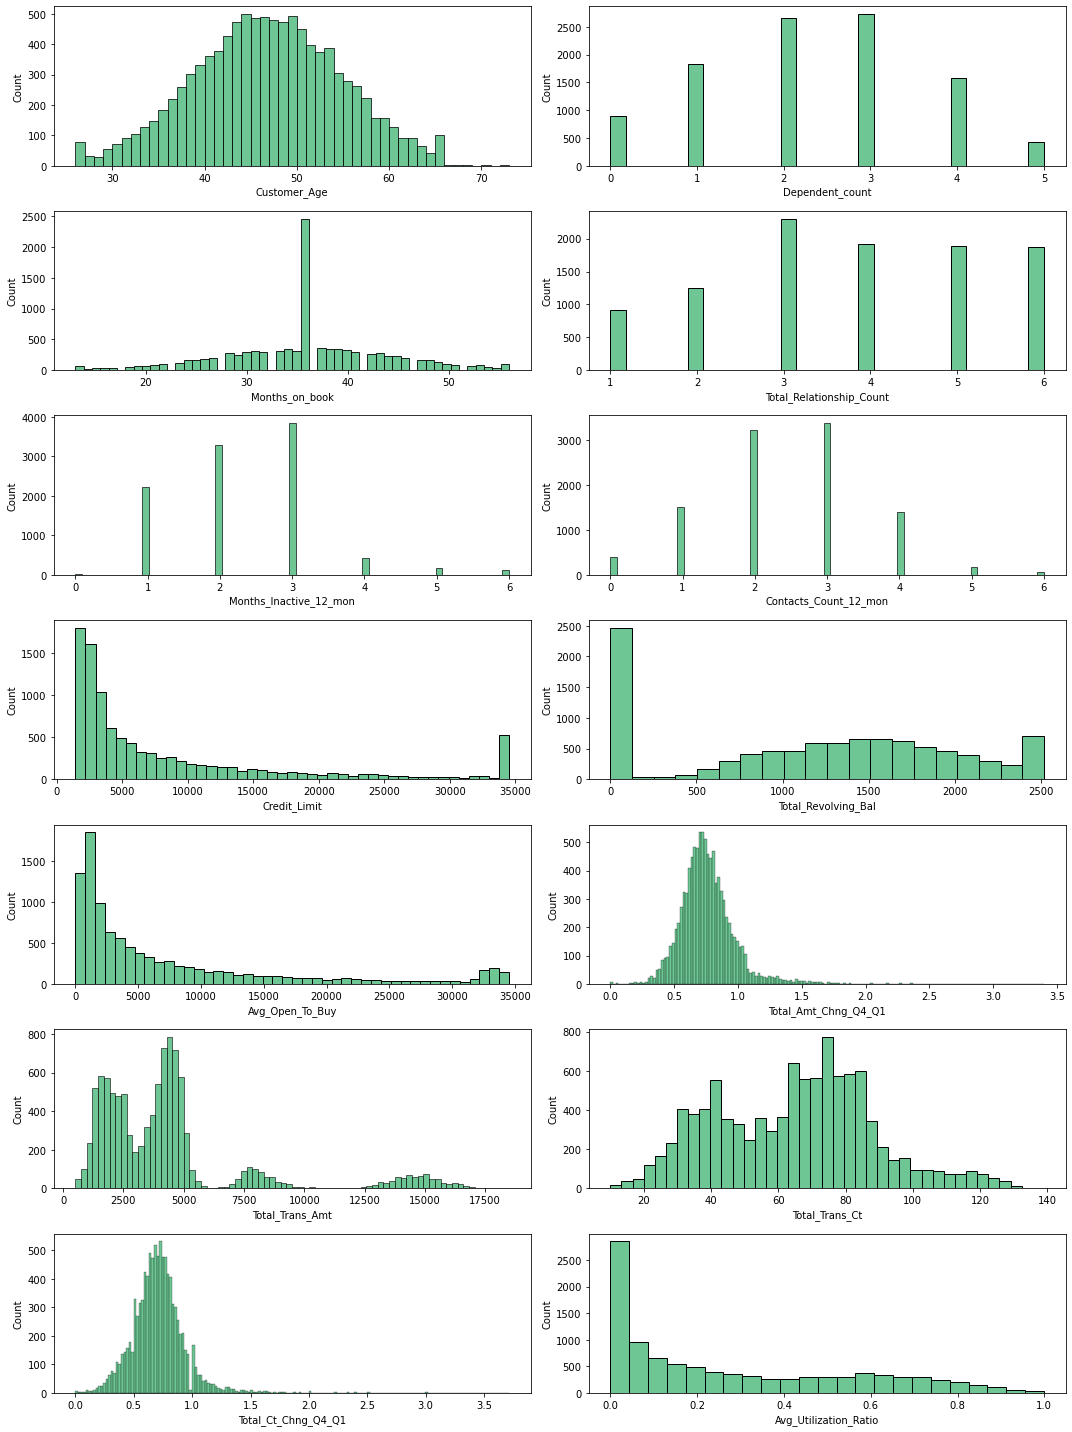

In [10]:
num = list(dfDrop.describe().columns)
plt.figure(figsize=(15, 20))
for i in range(0, len(num)):
    plt.subplot(7, 2, i+1)
    sns.histplot(x=dfDrop[num[i]], color='mediumseagreen')
    plt.xlabel(num[i])
    plt.tight_layout()

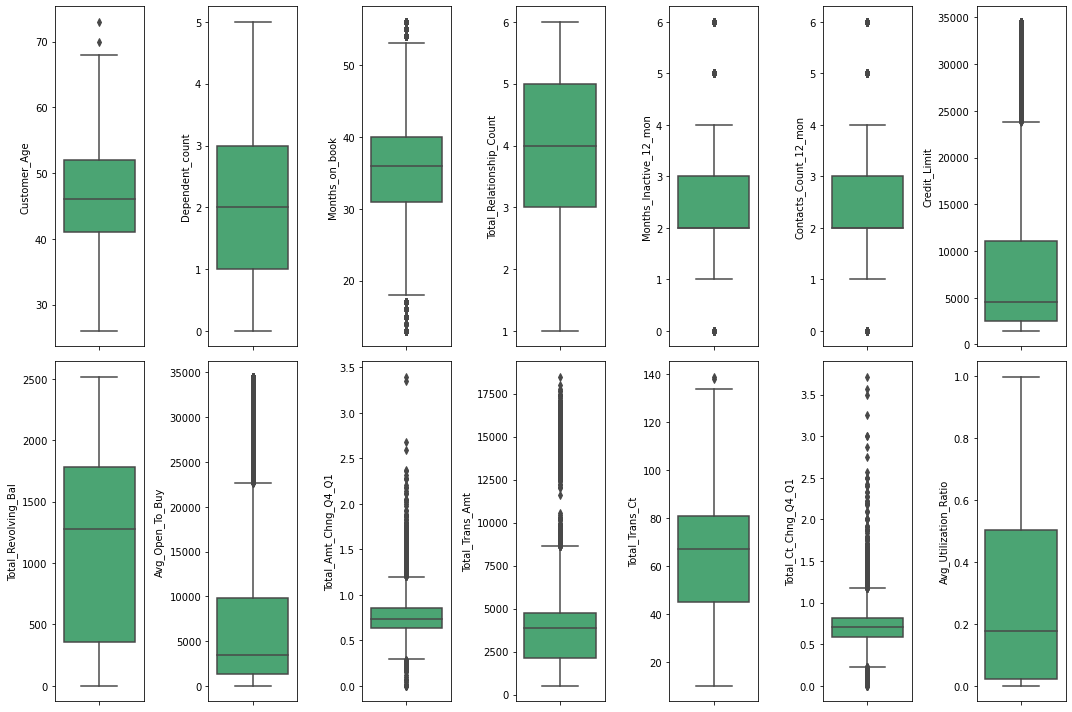

In [11]:
num = list(dfDrop.describe().columns)
plt.figure(figsize=(15,10))
for i in range(0, len(num)):
    plt.subplot(2, 7, i+1)
    sns.boxplot(y=dfDrop[num[i]], color='mediumseagreen', orient='v')
    plt.tight_layout()

#### Categorical

In [12]:
dfDrop.describe(include='object').T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


- imbalance target (Attrition_Flag) --> over/undersampling later

In [13]:
cat = list(dfDrop.describe(include='object').columns)
for i in cat:
    print(dfDrop[i].value_counts())

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
F    5358
M    4769
Name: Gender, dtype: int64
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


- Label encode: `Attrition_Flag`, `Gender`, and `Income_Category`
- The rest will be one-hot encoded

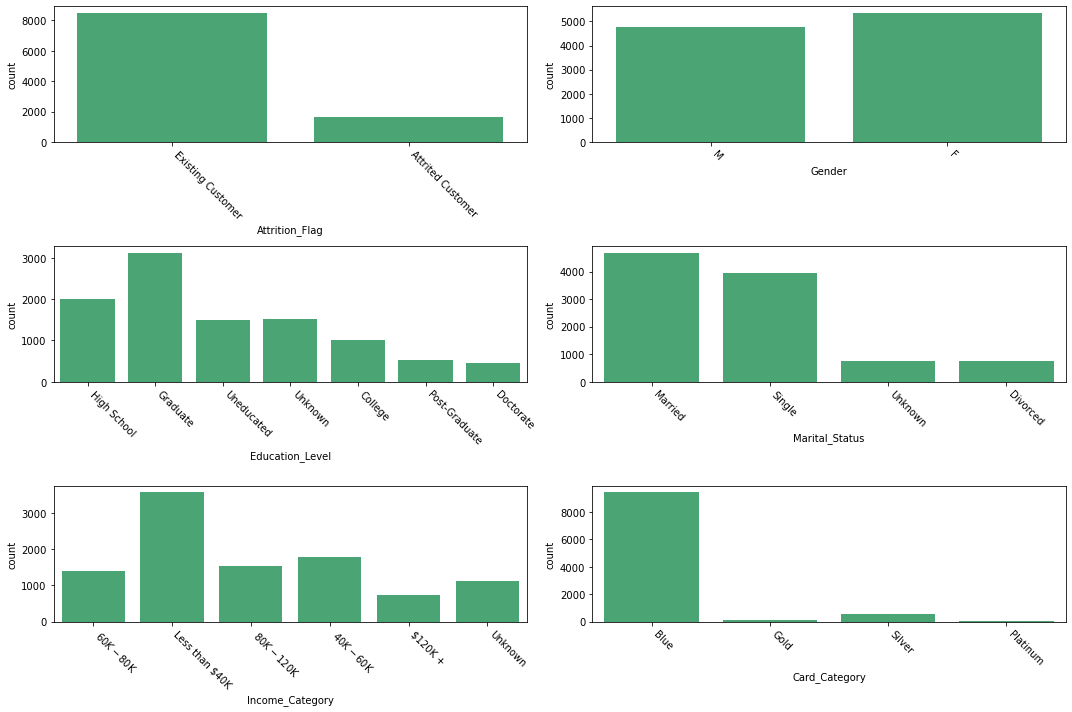

In [14]:
cat = list(dfDrop.describe(include='object').columns)
plt.figure(figsize=(15,10))
for i in range(0, len(cat)):
    plt.subplot(3, 2, i+1)
    sns.countplot(x = dfDrop[cat[i]], color='mediumseagreen', orient='v')
    plt.xticks(rotation=-45, ha='left')
    plt.tight_layout()

### Multivariat analysis

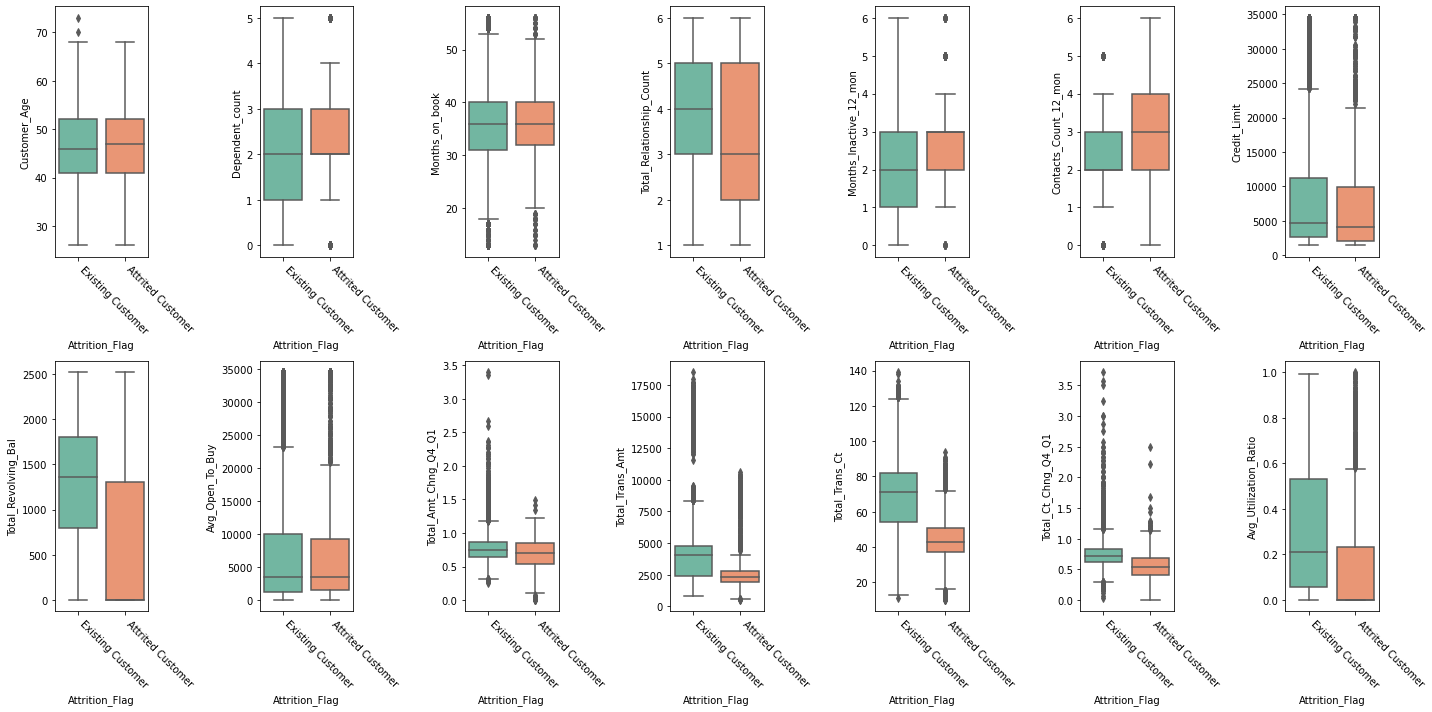

In [15]:
num = list(dfDrop.describe().columns)
plt.figure(figsize=(20,10))
for i in range(0, len(num)):
    plt.subplot(2, 7, i+1)
    sns.boxplot(y=dfDrop[num[i]], orient='v', x=dfDrop['Attrition_Flag'], palette="Set2")
    plt.xticks(rotation=-45, ha='left')
    plt.tight_layout()

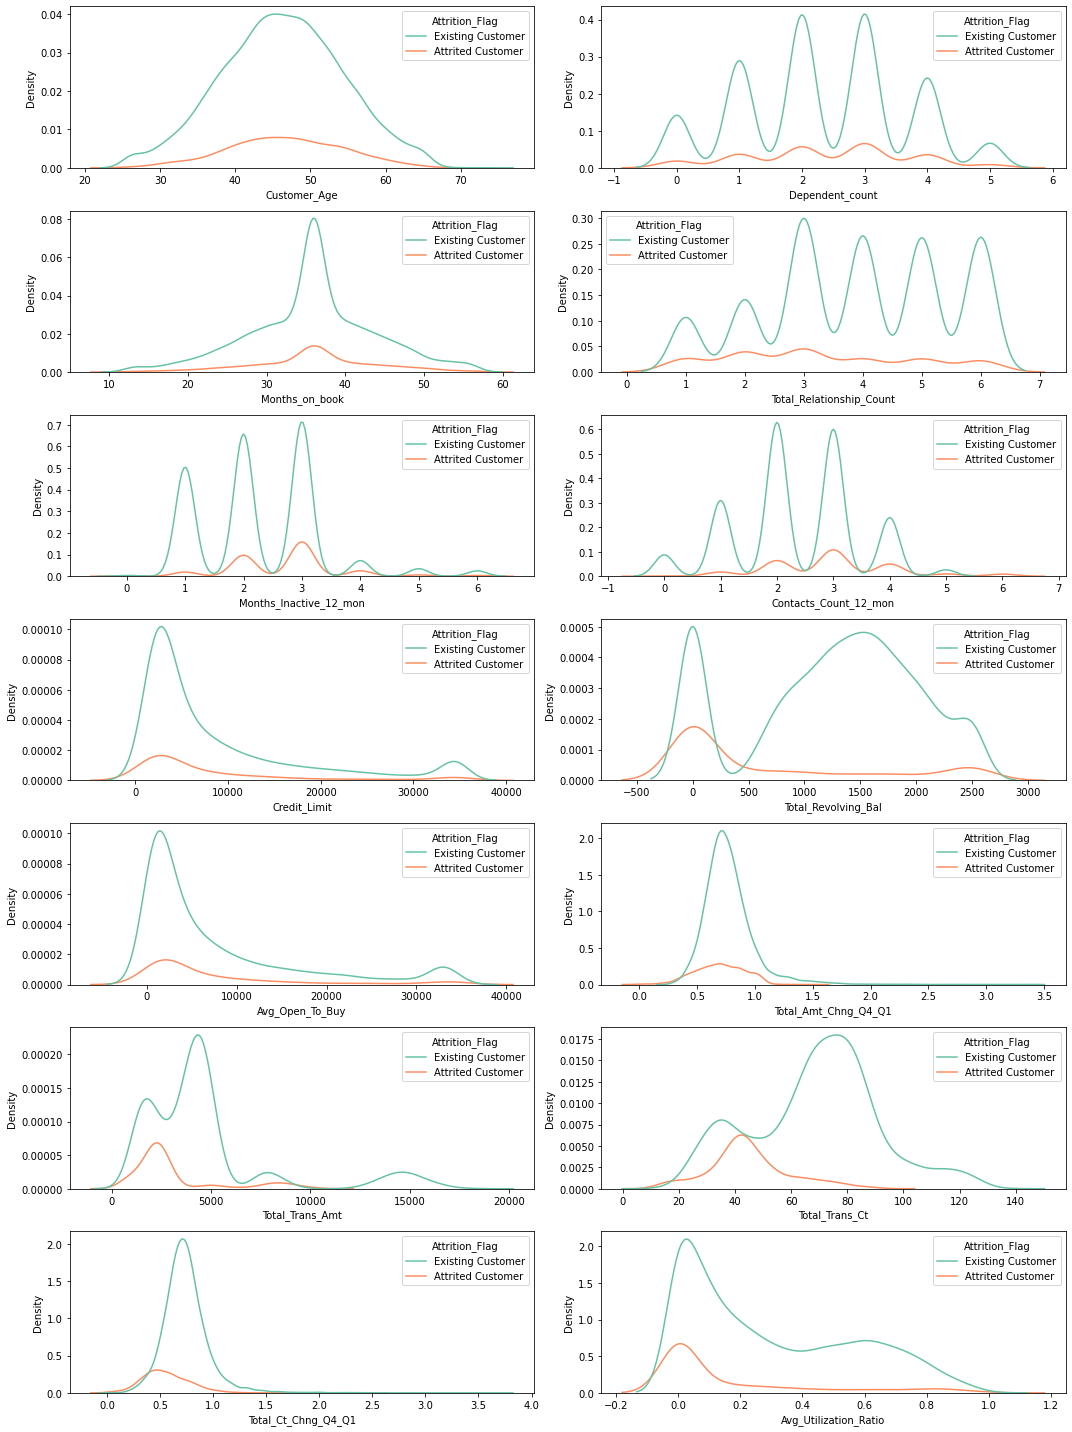

In [16]:
num = list(dfDrop.describe().columns)
plt.figure(figsize=(15, 20))
for i in range(0, len(num)):
    plt.subplot(7, 2, i+1)
    sns.kdeplot(x=dfDrop[num[i]], palette="Set2", hue=raw['Attrition_Flag'])
    plt.xlabel(num[i])
    plt.tight_layout()

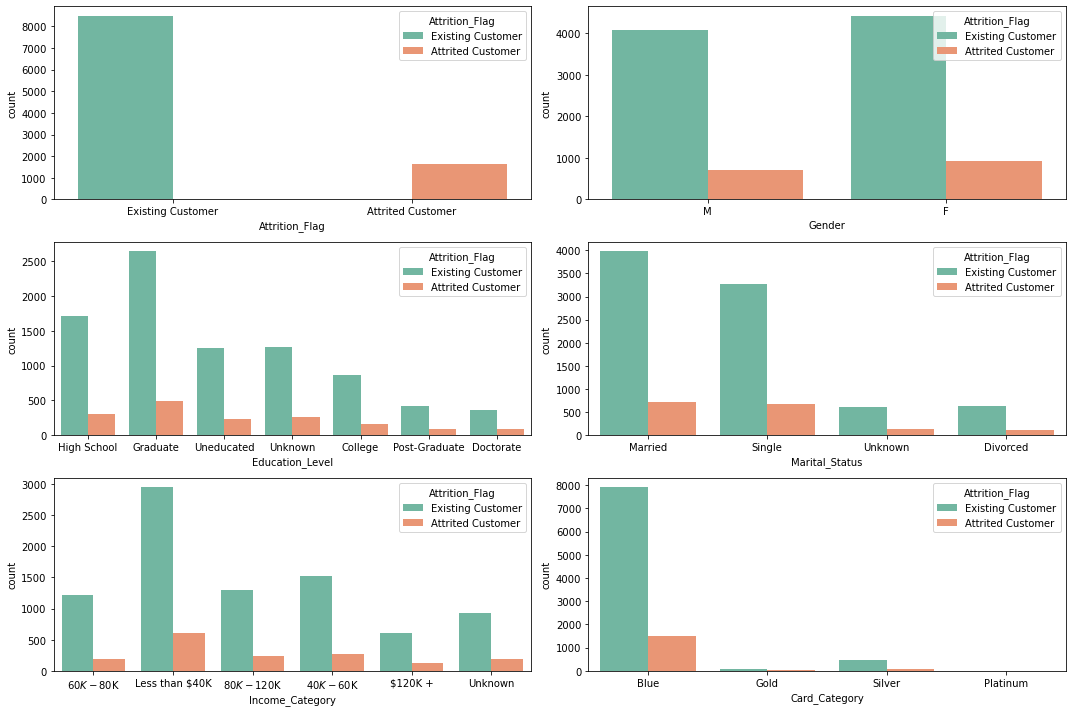

In [17]:
cat = list(dfDrop.describe(include='object').columns)
plt.figure(figsize=(15,10))
for i in range(0, len(cat)):
    plt.subplot(3, 2, i+1)
    sns.countplot(x = dfDrop[cat[i]], orient='v', hue=dfDrop['Attrition_Flag'], palette="Set2")
    plt.tight_layout()

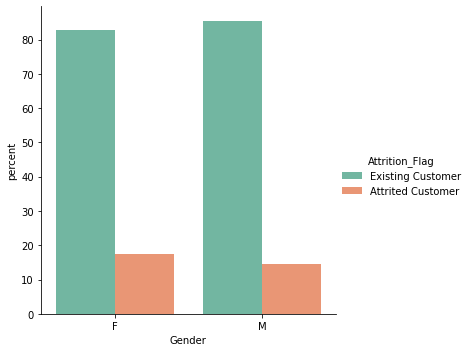

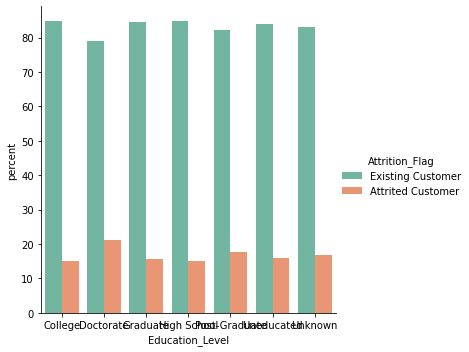

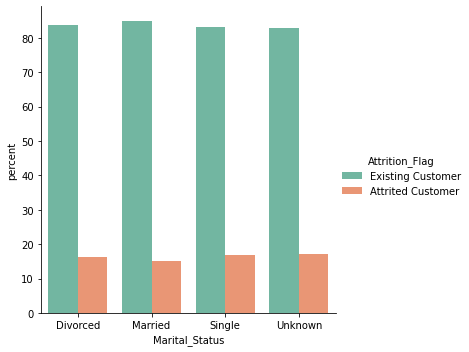

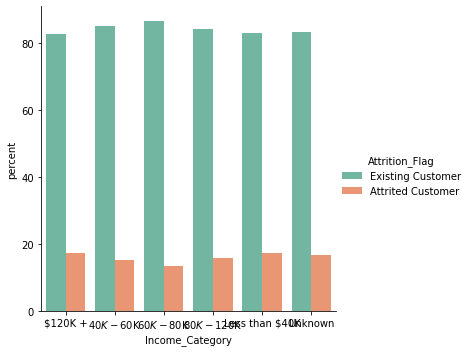

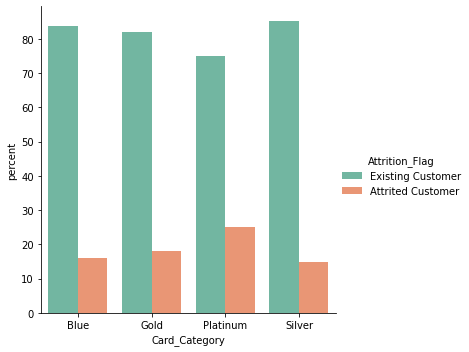

In [18]:
cat = list(dfDrop.describe(include='object'))
cat.remove('Attrition_Flag')
z = 0
for i in cat:
    (dfDrop
    .groupby(i)['Attrition_Flag']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pipe((sns.catplot,'data'), x=i,y='percent',hue='Attrition_Flag',kind='bar', palette='Set2'))
    z += 1

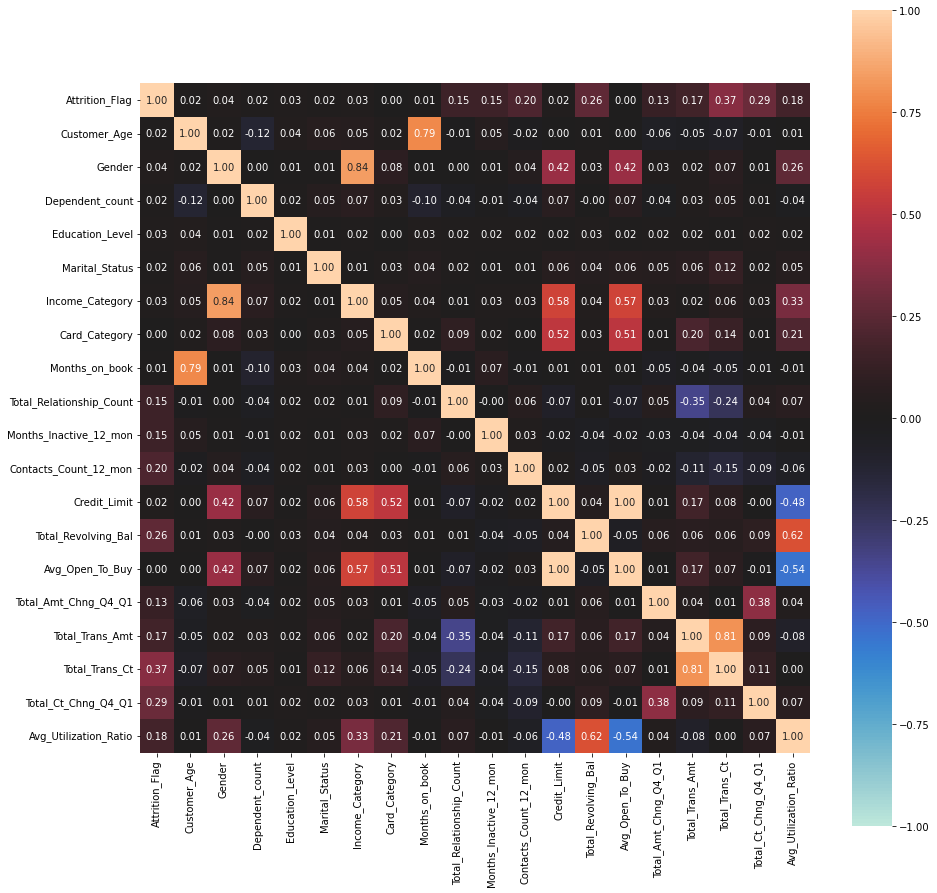

In [19]:
associations(dfDrop, figsize=(15,15), nan_strategy='drop_samples');

## Missing Values

In [20]:
dfMissing = dfDrop.copy()
dfMissing.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

## Feature Engineering

### Label encoding

In [21]:
dfLabel = dfMissing.copy()
dfLabel.describe(include='object')

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


In [22]:
mapAttrition = {'Attrited Customer':1, 'Existing Customer':0}
mapGender = {'M':1, 'F':0}
mapCard = {'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3}

dfLabel['Attrition_Flag'] = dfLabel['Attrition_Flag'].map(mapAttrition)
dfLabel['Gender'] = dfLabel['Gender'].map(mapGender)
dfLabel['Card_Category'] = dfLabel['Card_Category'].map(mapCard)

dfLabel[['Attrition_Flag','Gender','Card_Category']].sample(5)

,Attrition_Flag,Gender,Card_Category
3851,1,1,0
9241,0,1,0
2184,0,0,0
9752,1,1,0
818,0,0,0


### One-hot encoding

In [23]:
dfOHE = dfLabel.copy()
dfOHE.describe(include='object')

,Education_Level,Marital_Status,Income_Category
count,10127,10127,10127
unique,7,4,6
top,Graduate,Married,Less than $40K
freq,3128,4687,3561


In [24]:
cat = list(dfOHE.describe(include='object').columns)
for feature in cat:
    onehots = pd.get_dummies(dfOHE[feature], prefix=feature)
    dfOHE = dfOHE.join(onehots).drop(feature, axis=1)
dfOHE.sample(3)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown
7307,1,37,0,3,0,21,4,2,2,1784.0,577,1207.0,0.542,2348,47,0.516,0.323,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4862,0,48,0,3,0,36,6,2,2,2545.0,1894,651.0,0.911,4660,68,0.789,0.744,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
6865,0,55,0,1,0,42,4,5,3,1438.3,0,1438.3,0.740,4956,72,0.714,0.000,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


## Machine learning modelling

### Variable Declaration

In [25]:
dfFinal = dfOHE.copy()
y = dfFinal.loc[:,'Attrition_Flag']
x = dfFinal.loc[:, dfFinal.columns!='Attrition_Flag']

### Train Test Split

In [26]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= 0.2, random_state=42, stratify=y)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((8101, 33), (2026, 33), (8101,), (2026,))

### Standardizing

In [27]:
sc = StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)
xtest_sc = sc.transform(xtest)

### Oversampling

In [28]:
counter = Counter(ytrain)
print('Before', counter)

smt = SMOTE(sampling_strategy=0.5)
xtrain_scsm, ytrain_scsm = smt.fit_resample(xtrain_sc, ytrain)

counter = Counter(ytrain_scsm)
print('After', counter)

Before Counter({0: 6799, 1: 1302})
After Counter({0: 6799, 1: 3399})


### Fitting and Model Evaluation

In [29]:
%%time
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xg = XGBClassifier(use_label_encoder=False)
cb = CatBoostClassifier(random_state=42, silent=True)

model = [logreg, knn, dt, rf, xg, cb]
me_sum = pd.DataFrame({'model':[],'accuracytrain':[],'accuracytest':[],'precision':[],'recall':[],'rocauc':[]})

for i in model:
    i.fit(xtrain_scsm, ytrain_scsm)
    ytrainpredict = i.predict(xtrain_scsm)
    ytestpredict = i.predict(xtest_sc)
    accuracytrain = round(accuracy_score(ytrain_scsm, ytrainpredict),3)
    accuracytest = round(accuracy_score(ytest, ytestpredict),3)
    precision = round(precision_score(ytest, ytestpredict),3)
    recall = round(recall_score(ytest, ytestpredict),3)
    rocauc = round(roc_auc_score(ytest, ytestpredict),3)
    name = f'{i}'.split('(')[0]
    me_sum = me_sum.append({'model':name, 
                            'accuracytrain':accuracytrain,
                            'accuracytest':accuracytest,
                            'precision':precision,
                            'recall':recall,
                            'rocauc':rocauc
                           }, ignore_index=True)
    print(name)
    print(classification_report(ytest, ytestpredict))
me_sum

LogisticRegression
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1701
           1       0.66      0.73      0.69       325

    accuracy                           0.90      2026
   macro avg       0.80      0.83      0.81      2026
weighted avg       0.90      0.90      0.90      2026

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1701
           1       0.43      0.53      0.47       325

    accuracy                           0.81      2026
   macro avg       0.67      0.70      0.68      2026
weighted avg       0.83      0.81      0.82      2026

DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1701
           1       0.78      0.79      0.78       325

    accuracy                           0.93      2026
   macro avg       0.87      0.87      0.87      2026
weighted av

,model,accuracytrain,accuracytest,precision,recall,rocauc
0,LogisticRegression,0.876,0.895,0.657,0.729,0.828
1,KNeighborsClassifier,0.927,0.812,0.431,0.526,0.697
2,DecisionTreeClassifier,1.000,0.929,0.776,0.788,0.872
3,RandomForestClassifier,1.000,0.952,0.888,0.803,0.892
4,XGBClassifier,1.000,0.971,0.935,0.880,0.934
5,<catboost.core.CatBoostClassifier object at 0x...,0.998,0.972,0.950,0.874,0.933


- Default XGB has the highest recall and rocauc score

### Hyperparameter tuning

In [30]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.uniform ('gamma', 0,9),
         'reg_alpha' : hp.quniform('reg_alpha', 0, 180, 1),
         'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': hp.quniform('n_estimators', 80, 180, 10),
         'seed': 0
        }

In [31]:
def objective(space):
    clf = XGBClassifier(n_estimators =int(space['n_estimators']), 
                        max_depth = int(space['max_depth']), 
                        gamma = space['gamma'], 
                        reg_alpha = int(space['reg_alpha']),
                        min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']),
                        use_label_encoder=False
                       )
    
    evaluation = [(xtrain_scsm, ytrain_scsm), (xtest_sc, ytest)]
    
    clf.fit(xtrain_scsm, ytrain_scsm,
            eval_set=evaluation, 
            eval_metric="auc",
            early_stopping_rounds=10,
            verbose=False)

    pred = clf.predict(xtest_sc)
    accuracy = accuracy_score(ytest, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [32]:
%%time
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                       )

SCORE:                                                 
0.9002961500493584                                     
SCORE:                                                                            
0.9106614017769002                                                                
SCORE:                                                                            
0.8919052319842053                                                                
SCORE:                                                                            
0.9067127344521224                                                                
SCORE:                                                                            
0.9175715695952616                                                                
SCORE:                                                                            
0.9067127344521224                                                                
SCORE:                                                    

In [33]:
best_hyperparams

{'colsample_bytree': 0.6688210672002076,
 'gamma': 7.1421955802731905,
 'max_depth': 3.0,
 'min_child_weight': 5.0,
 'n_estimators': 100.0,
 'reg_alpha': 1.0,
 'reg_lambda': 0.4307538133277618}

### Refitting model

In [34]:
xgb = XGBClassifier(colsample_bytree= 0.8084282287367451,
                    gamma= 3.3166101489031217,
                    max_depth= 9,
                    min_child_weight= 3.0,
                    reg_alpha= 0.0,
                    reg_lambda= 0.43820302462588073,
                    n_estimators= 150
                   )
xgb.fit(xtrain_scsm, ytrain_scsm)

[14:47:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\7.APPS\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8084282287367451,
              enable_categorical=False, gamma=3.3166101489031217, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=3.0, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.0,
              reg_lambda=0.43820302462588073, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
ytrainpredict = xgb.predict(xtrain_scsm)
ytestpredict = xgb.predict(xtest_sc)

In [36]:
print(classification_report(ytrain_scsm, ytrainpredict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6799
           1       0.99      0.99      0.99      3399

    accuracy                           1.00     10198
   macro avg       1.00      1.00      1.00     10198
weighted avg       1.00      1.00      1.00     10198



In [37]:
print(classification_report(ytestpredict, ytest))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1724
           1       0.86      0.93      0.89       302

    accuracy                           0.97      2026
   macro avg       0.92      0.95      0.94      2026
weighted avg       0.97      0.97      0.97      2026



In [38]:
print(roc_auc_score(ytestpredict, ytest))

0.9505251148568705


### Feature importances

In [39]:
fi = pd.DataFrame()
fi['features'] = list(x.columns.values)
fi['dt_importance'] = dt.feature_importances_*100
fi['rf_importance'] = rf.feature_importances_*100
fi['xg_importance'] = xg.feature_importances_*100
fi['cb_importance'] = cb.feature_importances_
best_features = pd.concat([fi.sort_values('dt_importance', ascending=False).head(5), fi.sort_values('rf_importance', ascending=False).head(3), fi.sort_values('xg_importance', ascending=False).head(3), fi.sort_values('cb_importance', ascending=False).head(3)]).drop_duplicates()
best_features

,features,dt_importance,rf_importance,xg_importance,cb_importance
13,Total_Trans_Ct,41.192811,18.375573,27.531099,25.708837
9,Total_Revolving_Bal,14.453288,10.259116,13.305786,5.689472
12,Total_Trans_Amt,11.061593,16.990873,5.016616,19.356341
5,Total_Relationship_Count,9.862218,6.151668,10.114323,9.280266
14,Total_Ct_Chng_Q4_Q1,6.735140,9.700945,4.110068,4.676671
6,Months_Inactive_12_mon,2.020152,5.536846,6.714231,9.595968


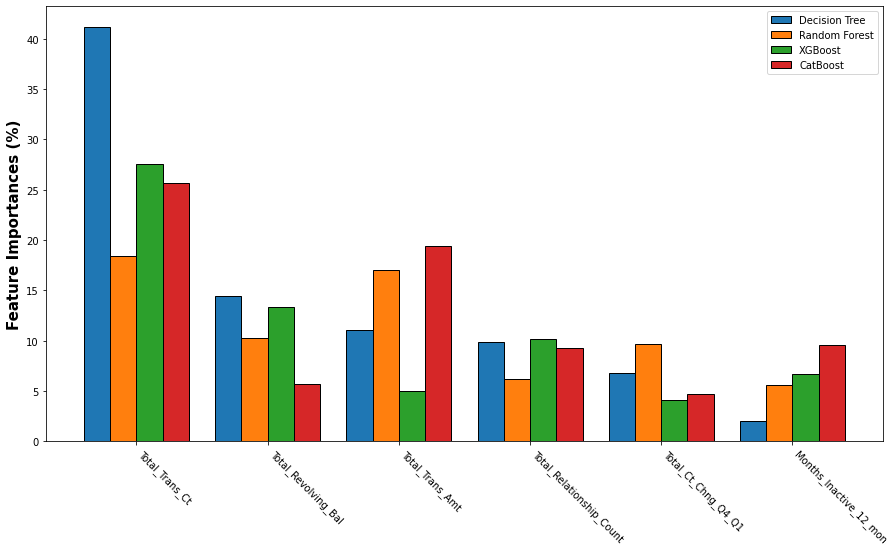

In [40]:
plt.figure(figsize=(15,8))

x_axis = np.arange(len(best_features['features']))
plt.bar(x_axis - 0.3, best_features['dt_importance'], label = 'Decision Tree', edgecolor='black',width=0.2)
plt.bar(x_axis - 0.1, best_features['rf_importance'], label = 'Random Forest', edgecolor='black',width=0.2)
plt.bar(x_axis + 0.1, best_features['xg_importance'], label = 'XGBoost', edgecolor='black',width=0.2)
plt.bar(x_axis + 0.3, best_features['cb_importance'], label = 'CatBoost', edgecolor='black',width=0.2)

plt.xticks(x_axis, best_features['features'], rotation=-45, ha='left')
plt.xlabel('', size=15, weight='bold')
plt.ylabel('Feature Importances (%)', size=15, weight='bold')
plt.legend();